## Introduction
---
Ever wondered if you should carry an umbrella tomorrow? With this dataset, you can predict next-day rain by training classification models on the target variable `RainTomorrow`.

### Dataset Overview
This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. It includes various meteorological variables such as temperature, humidity, wind speed, and more.

### Target Variable
- **RainTomorrow**: The target variable to predict. It answers the crucial question: will it rain the next day? (`Yes` or `No`).
  - This column is marked 'Yes' if the rain for that day was 1mm or more.

---

## Importing modules 

In [219]:

# Preprocessing and utilities

import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score


# Classification algorithms

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [140]:
# importing data 

data = pd.read_csv('weatherAUS.csv')

## Exploring data

In [141]:
# showing brief about the data
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [143]:
def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()

In [144]:
# Function to plot feature importances
def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [145]:
def chi_square_test(data, feature_col, target_col, alpha=0.05):
    """
    Perform a Chi-Square test to examine the relationship between two categorical variables.
    
    Parameters:
    - data: DataFrame containing the data.
    - feature_col: The name of the feature (categorical) column.
    - target_col: The name of the target (categorical) column.
    - alpha: Significance level for the test. Default is 0.05.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(data[feature_col], data[target_col])
    
    # Perform Chi-Square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f"Chi-Square test between '{feature_col}' and '{target_col}':")
    print(f"Chi-Square Statistic: {chi2_stat:.3f}")
    print(f"P-value: {p_val:.3f}")
    print(f"Degrees of Freedom: {dof}")
    
    # Check for statistical significance
    if p_val < alpha:
        print(f"The result is statistically significant (p < {alpha}).")
    else:
        print(f"The result is not statistically significant (p >= {alpha}).")
    
    # Visualize the contingency table as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Contingency Table Heatmap: {feature_col} vs {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(feature_col)

In [146]:
def ttest_two_categories(data, numerical_col, categorical_col, alpha=0.05):
    """
    Perform a t-test to compare the means of a numerical variable between two categories 
    and visualize the results. Also prints whether the result is statistically significant.
    """
    # Ensure there are exactly two categories
    if data[categorical_col].nunique() != 2:
        raise ValueError("The categorical column must have exactly two categories.")
    
    # Extract the categories
    categories = data[categorical_col].unique()
    group1 = data.loc[data[categorical_col] == categories[0], numerical_col]
    group2 = data.loc[data[categorical_col] == categories[1], numerical_col]
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

    # Print results
    print(f"T-test results between '{categories[0]}' and '{categories[1]}':")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_val:.3f}")
    
    # Check for statistical significance
    if p_val < alpha:
        print(f"The result is statistically significant (p < {alpha}).")
    else:
        print(f"The result is not statistically significant (p >= {alpha}).")
    
    # Create a box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')
    plt.title(f'Box Plot of {numerical_col} by {categorical_col}')
    plt.xlabel(categorical_col)
    plt.ylabel(numerical_col)
    plt.show()

In [147]:
# Creating a function to get null values

def nulls_df(df, column_type=None, percentage_threshold=0):
    """
    Computes the count and percentage of null values in a DataFrame using Dask for memory optimization.
    
    Args:
        df (dask.dataframe.DataFrame): The input Dask DataFrame.
        column_type (str, optional): The type of columns to filter ('Categorical' or 'Numerical').
        percentage_threshold (int, optional): The minimum percentage of null values to include.
        
    Returns:
        tuple: A tuple containing the filtered DataFrame and a list of column names.
    """
    
    # Compute null counts and percentages
    nulls_counts = df.isna().sum()
    nulls_percentages = (nulls_counts / df.shape[0]) * 100
    
    # Identify column types
    column_types = df.dtypes.apply(lambda x: 'Numerical' if x.kind in 'bifc' else 'Categorical')
    
    # Create a DataFrame for null information
    null_df = pd.DataFrame({
        'Column': nulls_counts.index,
        'Nulls_Count': nulls_counts,
        'Nulls_Percentage': nulls_percentages,
        'Type': column_types
    })
    
    # Filter based on column type if specified
    if column_type:
        null_df = null_df[null_df['Type'] == column_type]
    
    # Filter based on null percentage threshold
    null_df = null_df[null_df['Nulls_Percentage'] >= percentage_threshold]
    
    # Reset index to default numeric indices
    null_df = null_df.reset_index(drop=True)
    
    # Return the filtered DataFrame and a list of column names
    column_list = null_df['Column'].tolist()
    return null_df, column_list  

In [148]:
null_data_frame, null_column = nulls_df(data, percentage_threshold=0.1)
null_data_frame.sort_values(by='Nulls_Count')

,Column,Nulls_Count,Nulls_Percentage,Type
1,MaxTemp,1261,0.866905,Numerical
0,MinTemp,1485,1.020899,Numerical
17,Temp9am,1767,1.214767,Numerical
9,WindSpeed9am,1767,1.214767,Numerical
11,Humidity9am,2654,1.824557,Numerical
10,WindSpeed3pm,3062,2.105046,Numerical
19,RainToday,3261,2.241853,Categorical
2,Rainfall,3261,2.241853,Numerical
20,RainTomorrow,3267,2.245978,Categorical
18,Temp3pm,3609,2.481094,Numerical


## Data preprocessing 

In [149]:
# converting to datetime 
data['Date'] = pd.to_datetime(data['Date'])

In [150]:
duplicates = data.duplicated(subset=['Date', 'Location'], keep=False)
data[duplicates]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


* There is no duplicated values

In [151]:
# Getting numerical columns only

null_data_frame[null_data_frame['Type'] == "Numerical"]

,Column,Nulls_Count,Nulls_Percentage,Type
0,MinTemp,1485,1.020899,Numerical
1,MaxTemp,1261,0.866905,Numerical
2,Rainfall,3261,2.241853,Numerical
3,Evaporation,62790,43.166506,Numerical
4,Sunshine,69835,48.009762,Numerical
6,WindGustSpeed,10263,7.055548,Numerical
9,WindSpeed9am,1767,1.214767,Numerical
10,WindSpeed3pm,3062,2.105046,Numerical
11,Humidity9am,2654,1.824557,Numerical
12,Humidity3pm,4507,3.098446,Numerical


In [152]:
numerical_columns= null_data_frame[null_data_frame['Type'] == "Numerical"]["Column"].to_list()


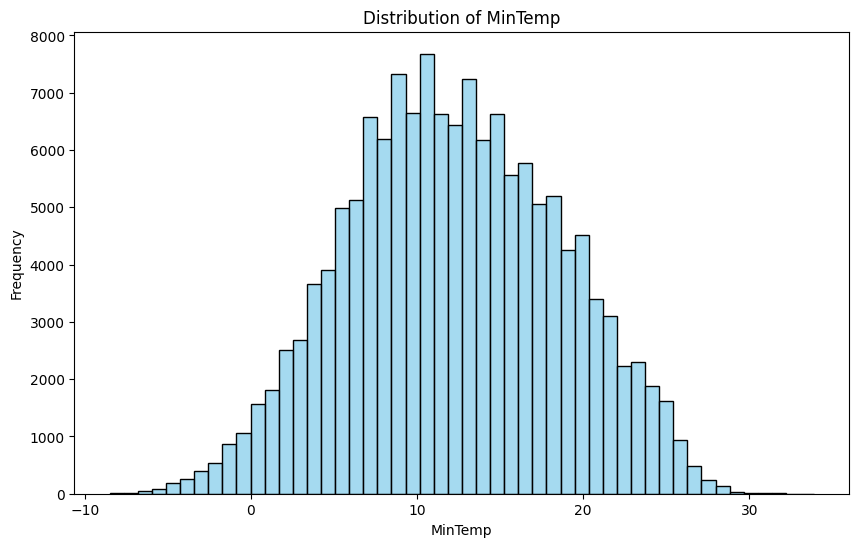

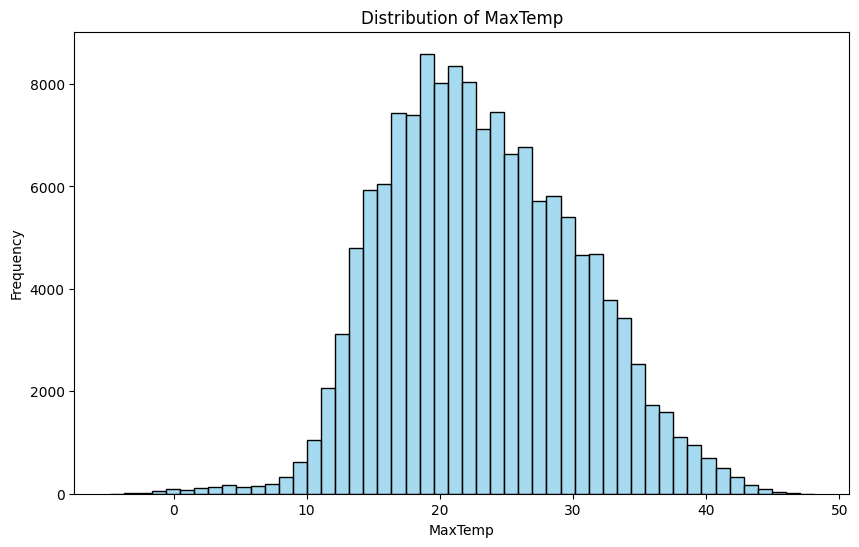

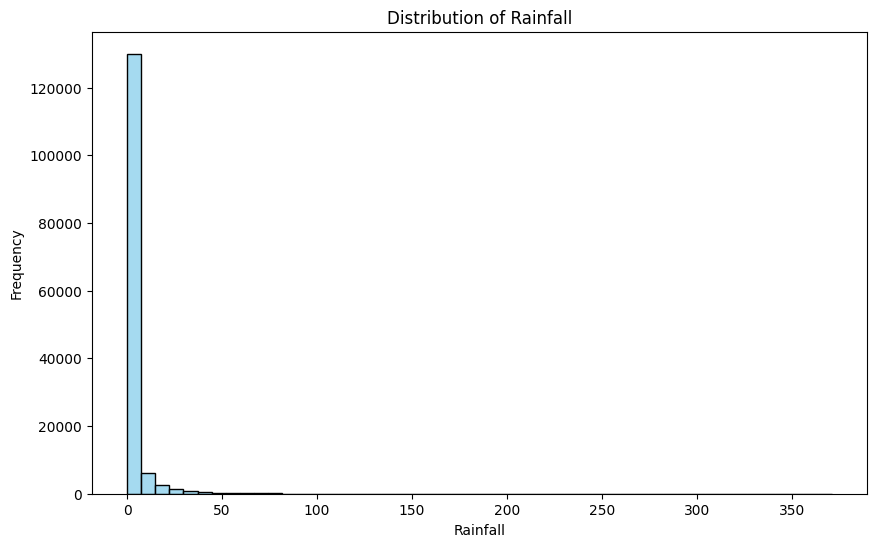

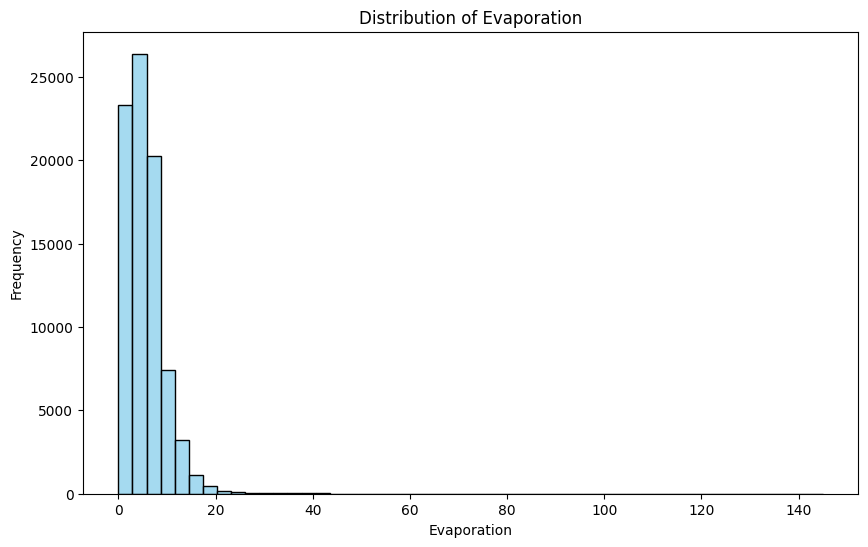

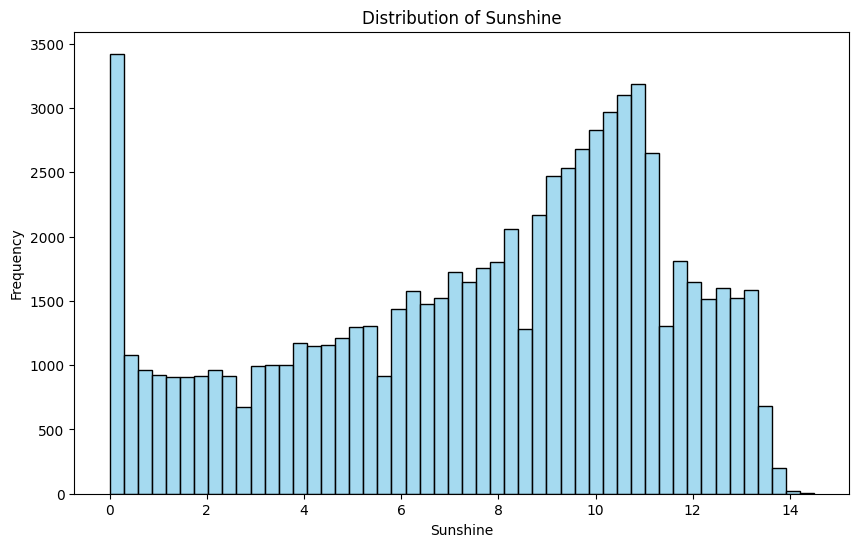

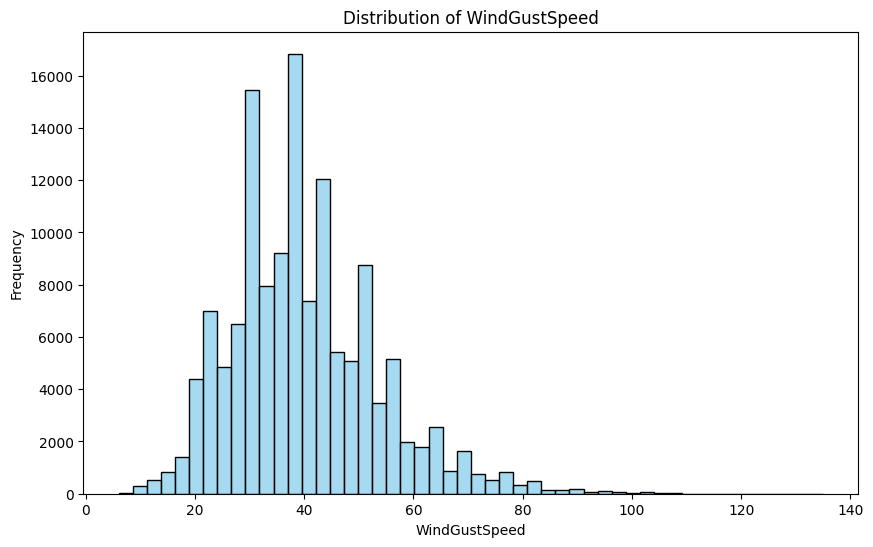

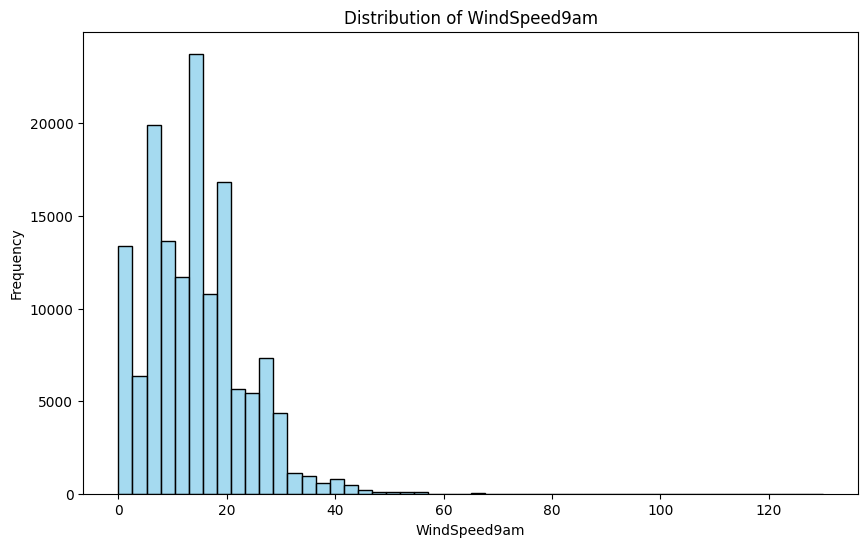

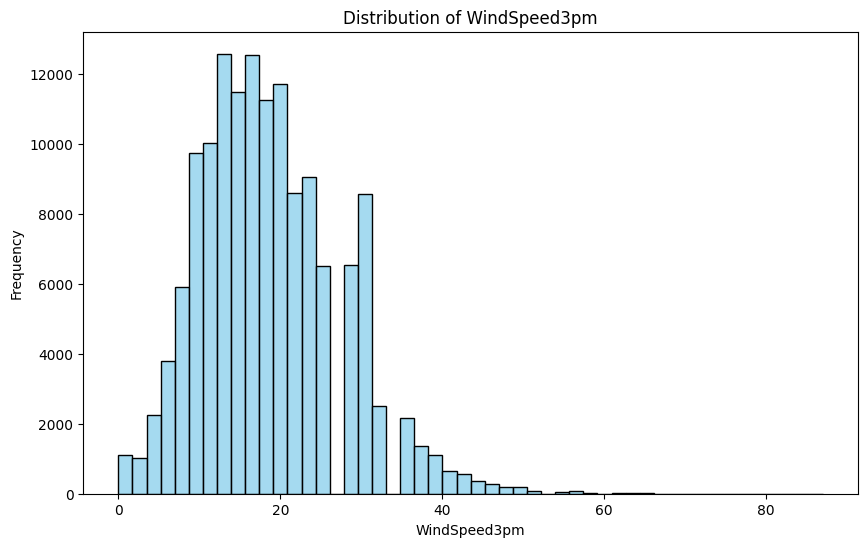

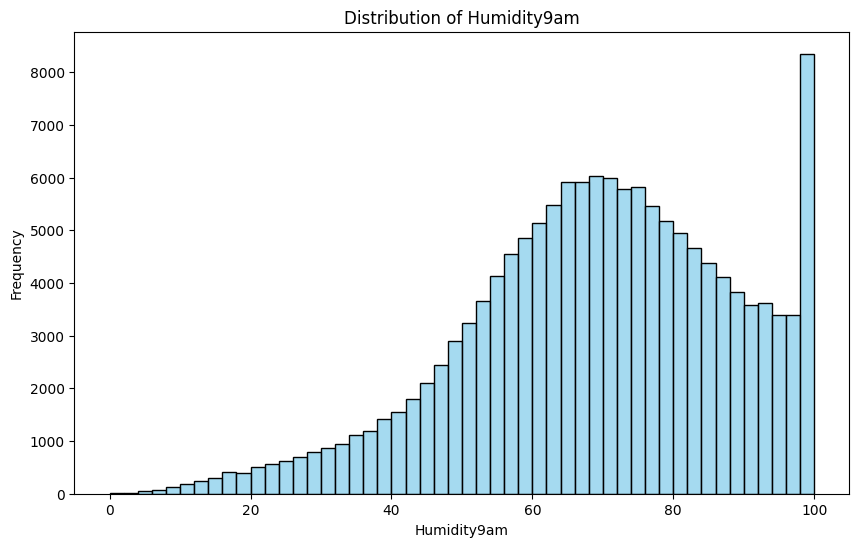

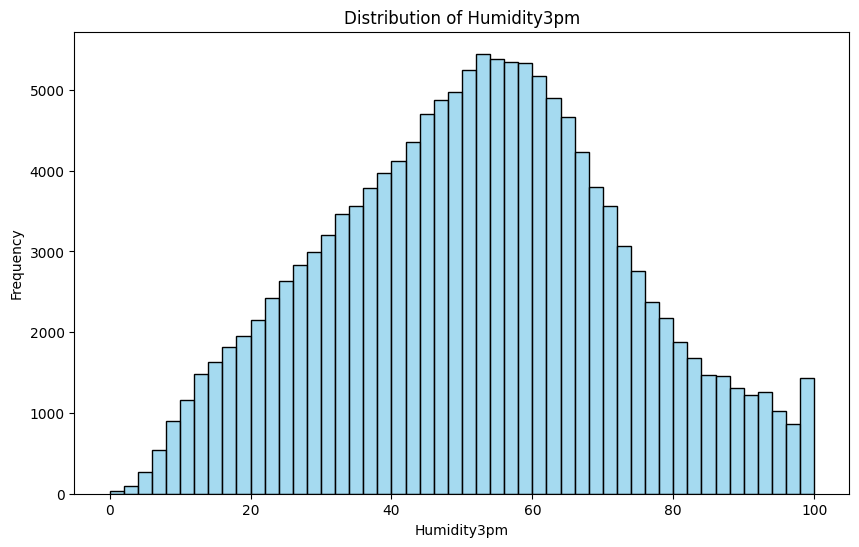

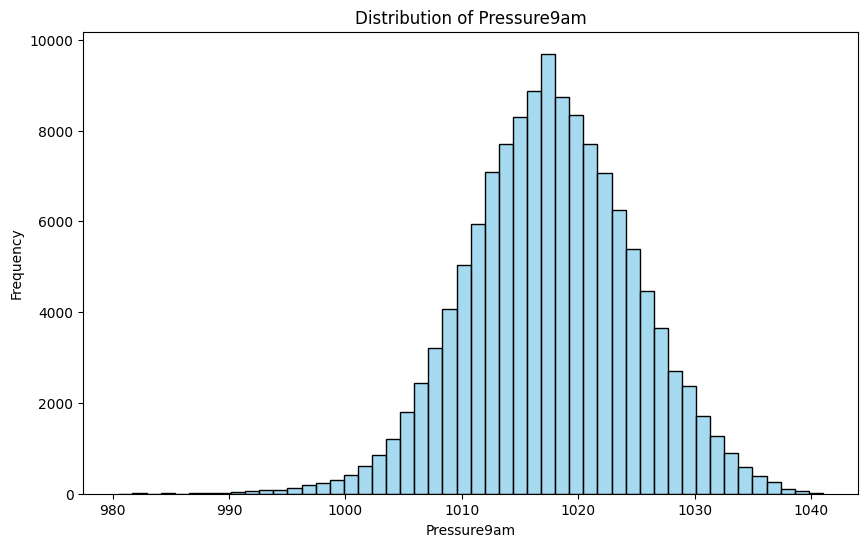

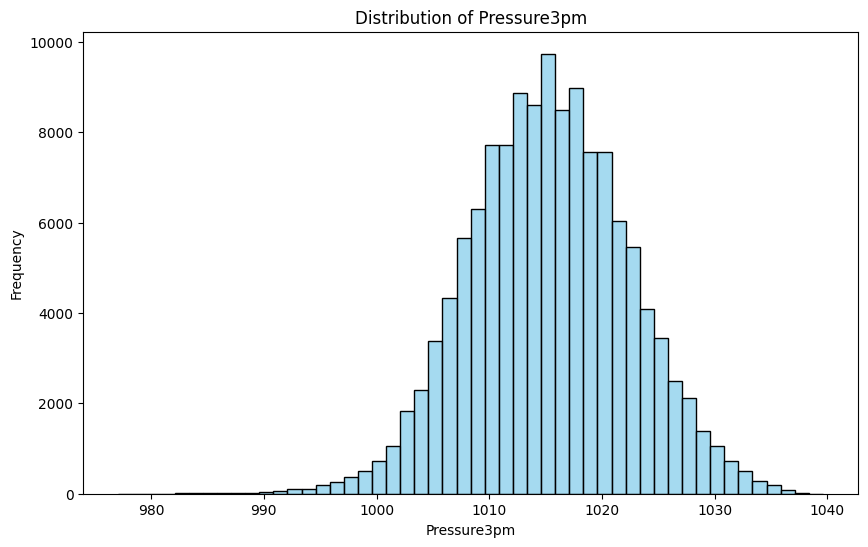

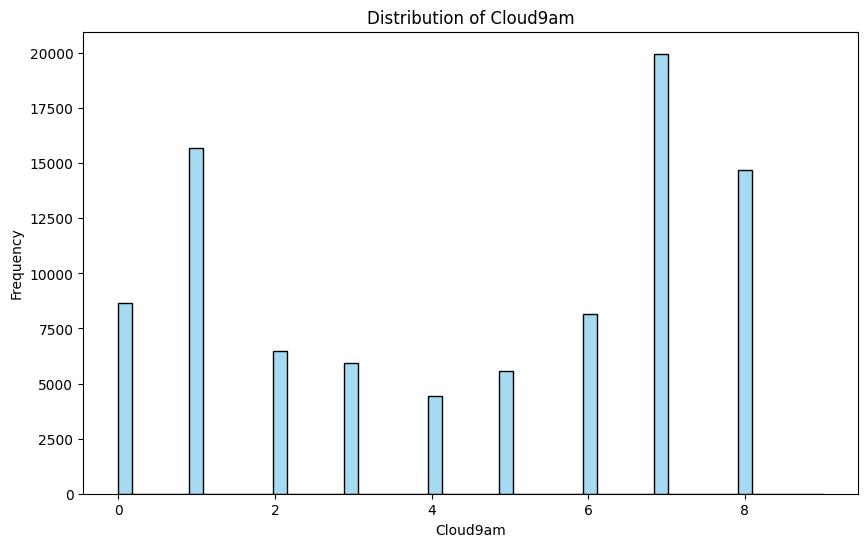

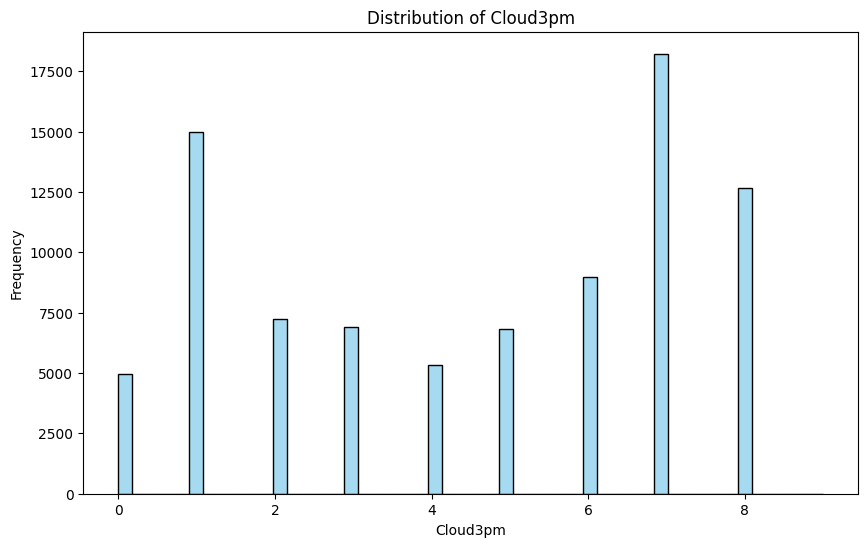

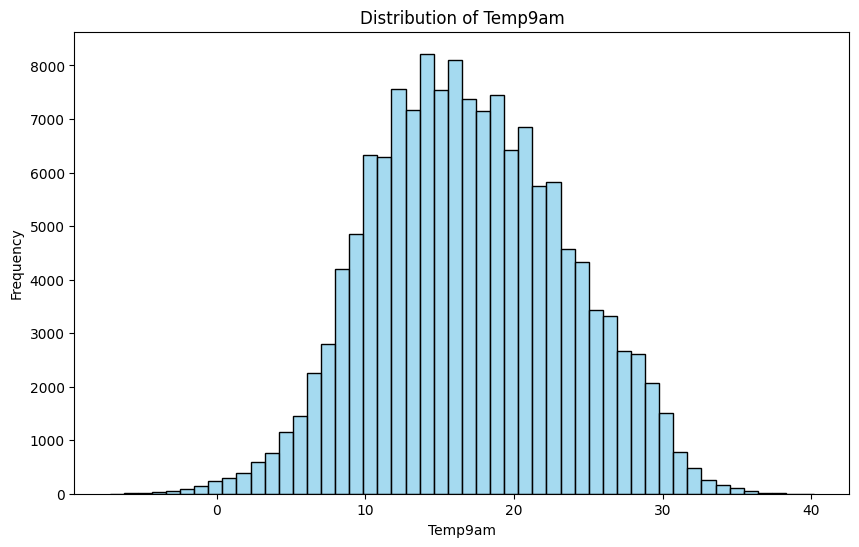

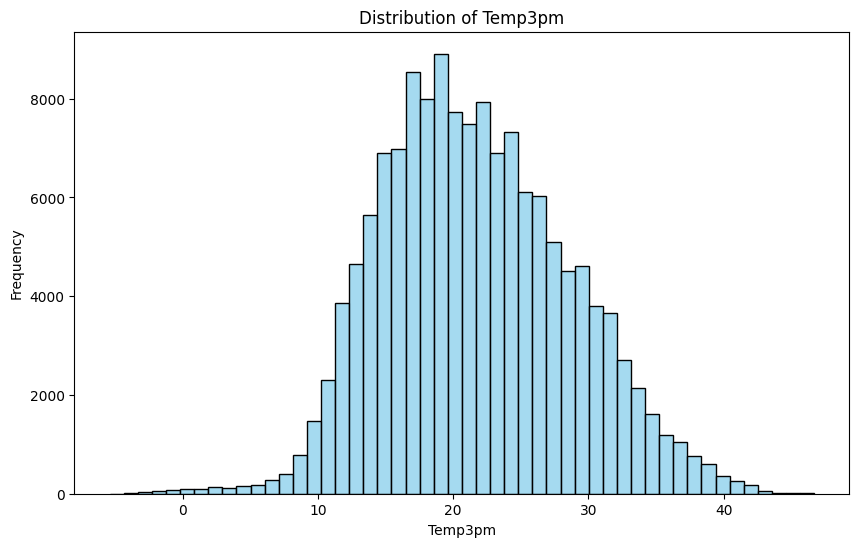

In [153]:
# Visualizing the MinTemp
for column in range(len(numerical_columns)):
    plot_histogram(data, numerical_columns[column], title=f'Distribution of {numerical_columns[column]}', xlabel=numerical_columns[column])

In [154]:
# Computing by mean in column that has a almost normal distribution 
mean_computing = ["MinTemp", "MaxTemp", "WindGustSpeed", "WindSpeed3pm", "Sunshine","Humidity3pm", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm"]
for column in range(len(mean_computing)):
    data[mean_computing[column]].fillna(data[mean_computing[column]].mean(), inplace = True)

/tmp/ipykernel_4231/3121986769.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[mean_computing[column]].fillna(data[mean_computing[column]].mean(), inplace = True)


In [155]:
null_data_frame, null_column = nulls_df(data, percentage_threshold=0.1)
null_data_frame.sort_values(by='Nulls_Count')

,Column,Nulls_Count,Nulls_Percentage,Type
5,WindSpeed9am,1767,1.214767,Numerical
6,Humidity9am,2654,1.824557,Numerical
0,Rainfall,3261,2.241853,Numerical
9,RainToday,3261,2.241853,Categorical
10,RainTomorrow,3267,2.245978,Categorical
4,WindDir3pm,4228,2.906641,Categorical
2,WindGustDir,10326,7.098859,Categorical
3,WindDir9am,10566,7.263853,Categorical
7,Cloud9am,55888,38.421559,Numerical
8,Cloud3pm,59358,40.807095,Numerical


In [156]:
median_computed = null_data_frame[null_data_frame['Type'] == "Numerical"]['Column'].to_list()

In [157]:
for column in range(len(median_computed)):
    data[median_computed[column]].fillna(data[median_computed[column]].median(), inplace = True)

/tmp/ipykernel_4231/1604798096.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[median_computed[column]].fillna(data[median_computed[column]].median(), inplace = True)
/tmp/ipykernel_4231/1604798096.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [158]:
null_data_frame, null_column = nulls_df(data, percentage_threshold=0.1)
null_data_frame.sort_values(by='Nulls_Count')

,Column,Nulls_Count,Nulls_Percentage,Type
3,RainToday,3261,2.241853,Categorical
4,RainTomorrow,3267,2.245978,Categorical
2,WindDir3pm,4228,2.906641,Categorical
0,WindGustDir,10326,7.098859,Categorical
1,WindDir9am,10566,7.263853,Categorical


Text(0.5, 1.0, 'Raintoday')

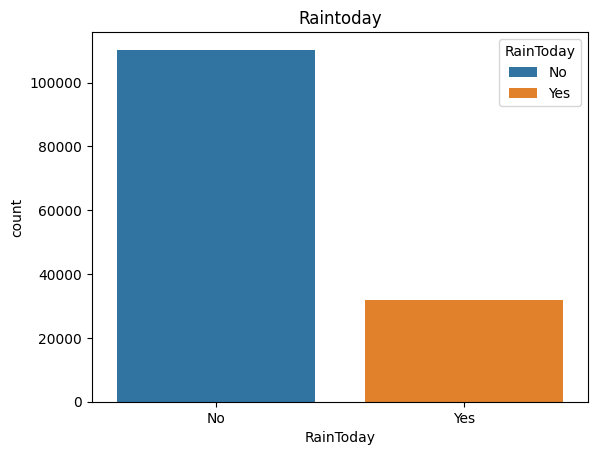

In [159]:
sns.countplot(data, x = 'RainToday', hue= "RainToday")
plt.title('Raintoday')

In [160]:
data['RainToday'].fillna("No", inplace= True)

/tmp/ipykernel_4231/1459135270.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['RainToday'].fillna("No", inplace= True)


In [161]:
null_data_frame, null_column = nulls_df(data, percentage_threshold=0.1)
null_data_frame.sort_values(by='Nulls_Count')

,Column,Nulls_Count,Nulls_Percentage,Type
3,RainTomorrow,3267,2.245978,Categorical
2,WindDir3pm,4228,2.906641,Categorical
0,WindGustDir,10326,7.098859,Categorical
1,WindDir9am,10566,7.263853,Categorical


In [162]:
for item in null_column:
    data[item].fillna(data[item].mode()[0], inplace=True)

/tmp/ipykernel_4231/906544286.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[item].fillna(data[item].mode()[0], inplace=True)


In [163]:
null_data_frame, null_column = nulls_df(data, percentage_threshold=0.1)
null_data_frame.sort_values(by='Nulls_Count')

,Column,Nulls_Count,Nulls_Percentage,Type


* Now there is no missing values in the data set

## EDA

In [164]:
## Deleting outliers by unsupervised learing algorithm 
from sklearn.svm import OneClassSVM




In [165]:
data.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,145460,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,2013-04-04 21:08:51.907053568,12.194034,23.221348,2.307990,5.179779,7.611178,40.035230,14.030751,18.662657,68.901251,51.539116,1017.649940,1015.255889,4.659755,4.709913,16.990631,21.683390
min,2007-11-01 00:00:00,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,2011-01-11 00:00:00,7.700000,18.000000,0.000000,4.000000,7.611178,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.100000,3.000000,4.000000,12.300000,16.700000
50%,2013-06-02 00:00:00,12.100000,22.700000,0.000000,4.800000,7.611178,39.000000,13.000000,18.662657,70.000000,51.539116,1017.649940,1015.255889,5.000000,5.000000,16.800000,21.400000
75%,2015-06-14 00:00:00,16.800000,28.200000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.200000
max,2017-06-25 00:00:00,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000
std,NaN,6.365750,7.088124,8.389771,3.178819,2.729486,13.118253,8.861796,8.716581,18.855360,20.471189,6.728467,6.663973,2.281490,2.106768,6.449221,6.850057


In [166]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,7.611178,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,7.611178,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,7.611178,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,7.611178,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,7.611178,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Text(0.5, 1.0, 'Count of Rain Tomorrow')

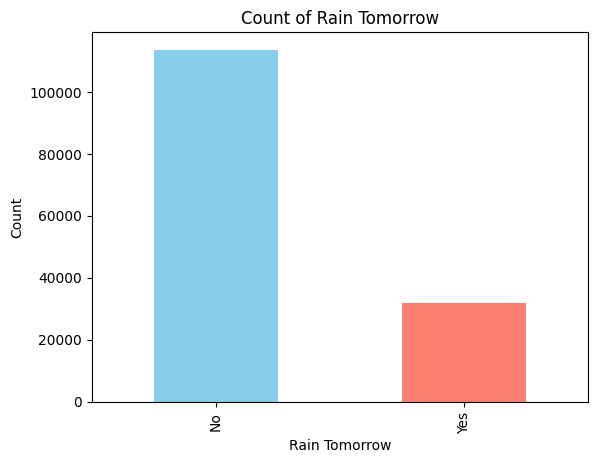

In [167]:
# Checking the Rain target variable

data['RainTomorrow'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.xlabel('Rain Tomorrow')
plt.ylabel('Count')
plt.title('Count of Rain Tomorrow')

* there is class inbalanced

T-test results between 'No' and 'Yes':
T-statistic: -31.601
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


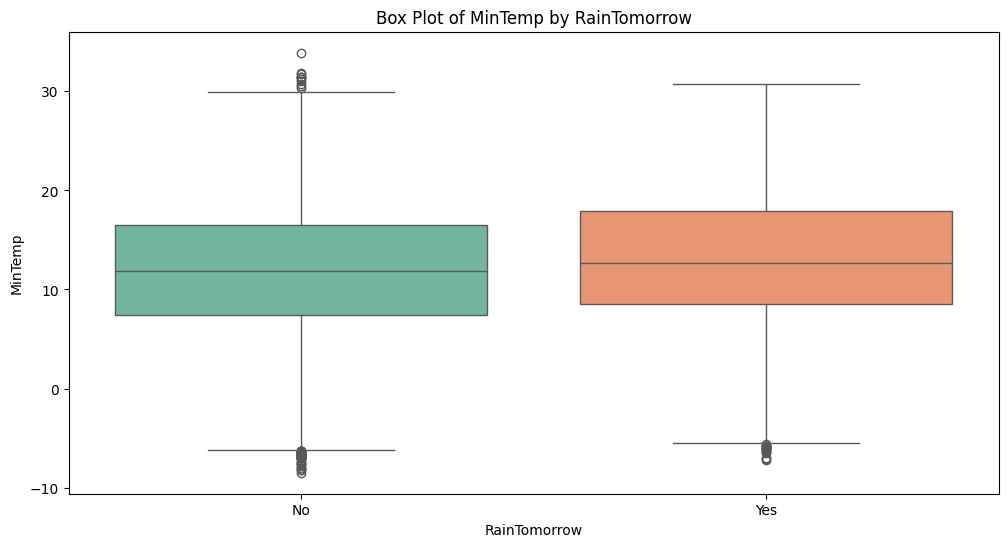

In [168]:
# Checking if there is a relation between MinTemp and RainTomowrrow
ttest_two_categories(data, 'MinTemp', 'RainTomorrow')

T-test results between 'No' and 'Yes':
T-statistic: 61.163
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


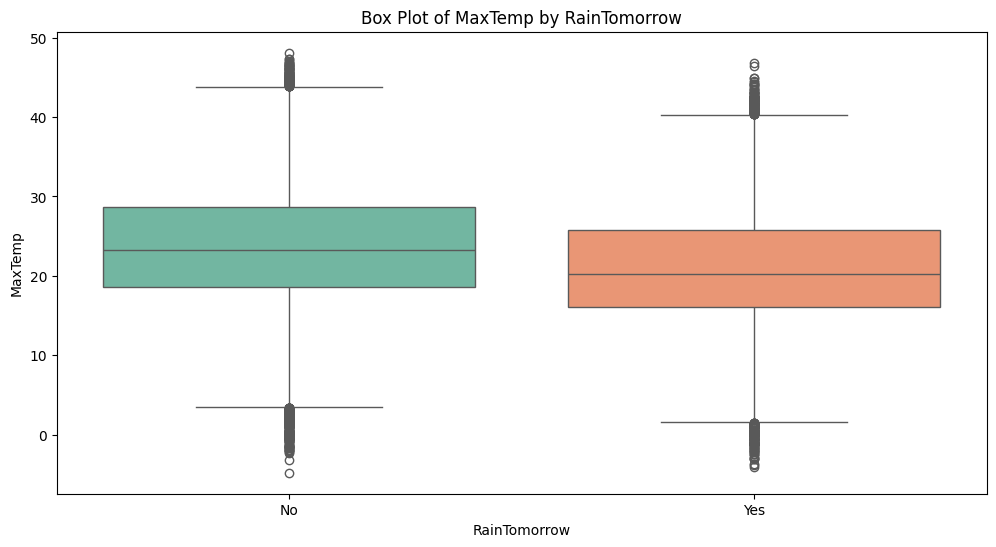

In [169]:
ttest_two_categories(data, 'MaxTemp', 'RainTomorrow')

In [170]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

T-test results between 'No' and 'Yes':
T-statistic: -58.511
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


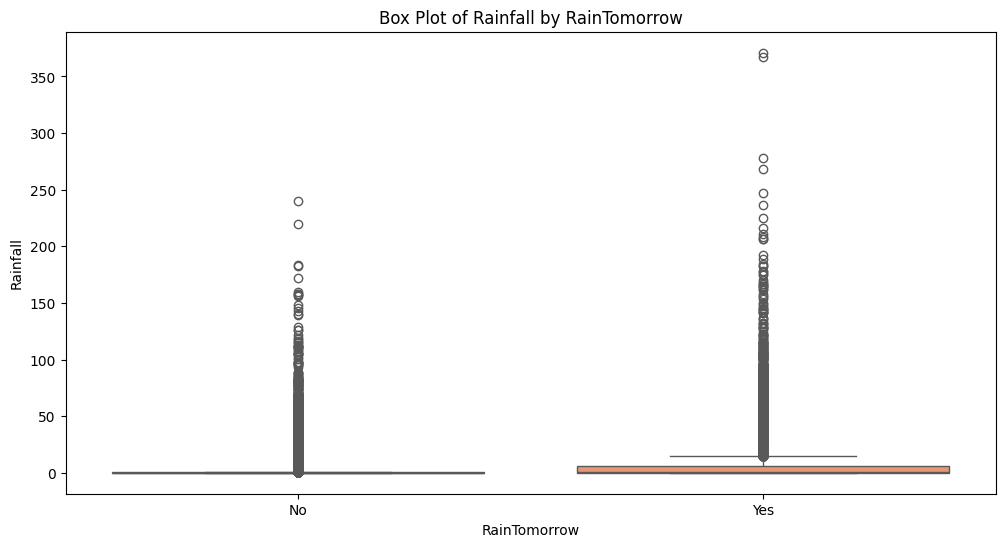

In [171]:
ttest_two_categories(data, 'Rainfall', 'RainTomorrow')

In [172]:
data['Evaporation'].value_counts()

Evaporation
4.8     64444
4.0      3339
8.0      2609
2.2      2095
2.0      2032
        ...  
17.1        1
19.7        1
20.5        1
18.1        1
39.6        1
Name: count, Length: 358, dtype: int64

<Axes: xlabel='Evaporation', ylabel='Count'>

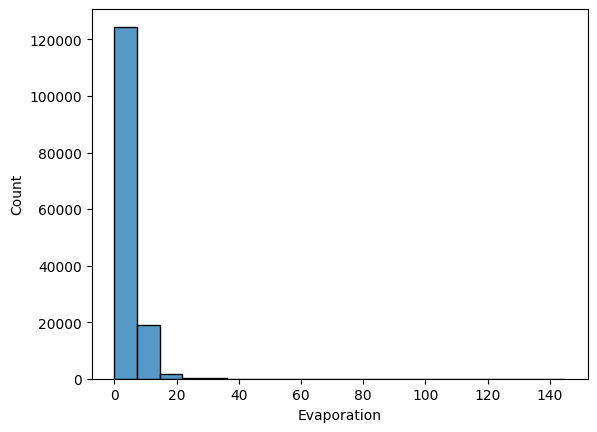

In [173]:
sns.histplot(data = data, x='Evaporation', bins=20)

T-test results between 'No' and 'Yes':
T-statistic: 38.817
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


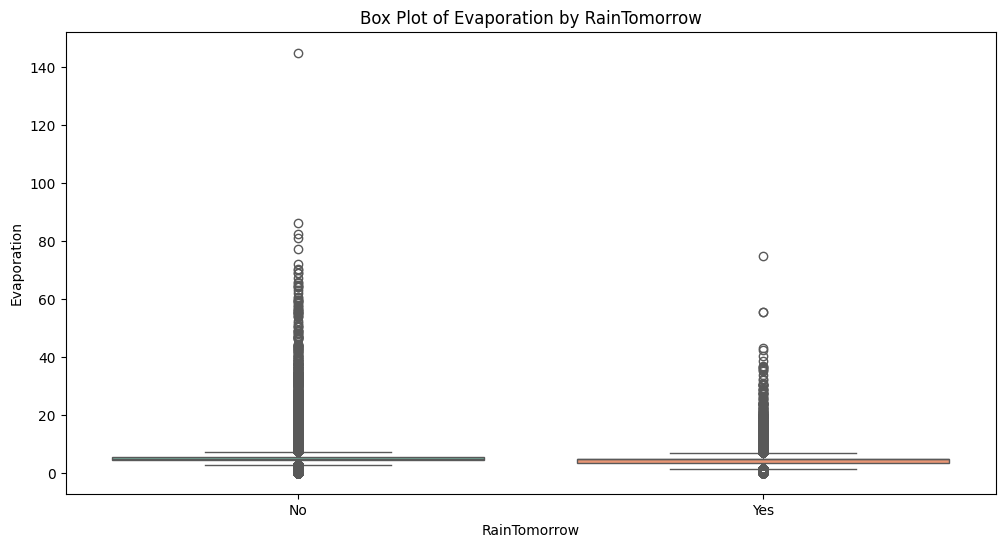

In [174]:
ttest_two_categories(data, 'Evaporation', 'RainTomorrow')

<Axes: xlabel='Sunshine', ylabel='Count'>

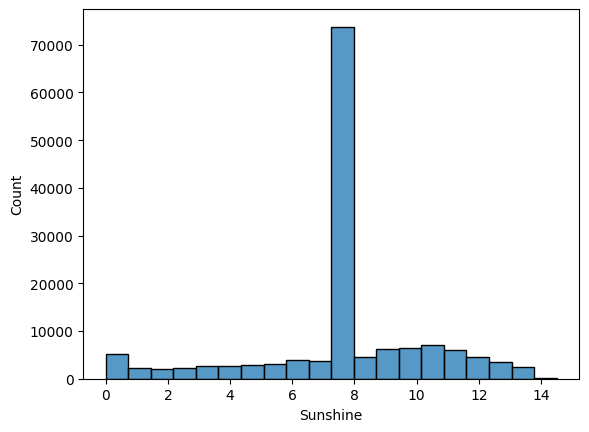

In [175]:
sns.histplot(data=data, x='Sunshine', bins=20)

T-test results between 'No' and 'Yes':
T-statistic: 118.896
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


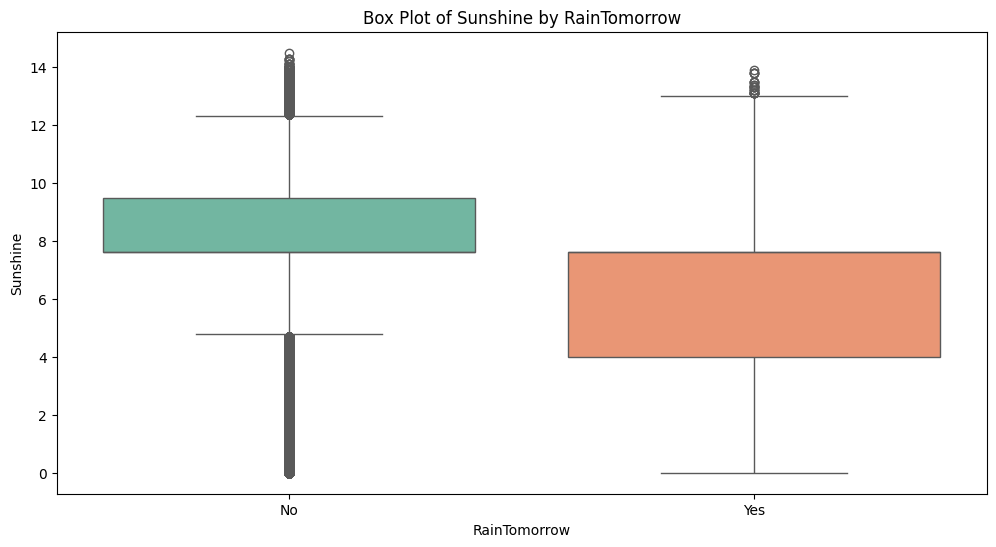

In [176]:
ttest_two_categories(data, 'Sunshine', 'RainTomorrow')

In [177]:
data.WindGustDir.value_counts()

WindGustDir
W      20241
SE      9418
N       9313
SSE     9216
E       9181
S       9168
WSW     9069
SW      8967
SSW     8736
WNW     8252
NW      8122
ENE     8104
ESE     7372
NE      7133
NNW     6620
NNE     6548
Name: count, dtype: int64

Chi-Square test between 'WindGustDir' and 'RainTomorrow':
Chi-Square Statistic: 1484.597
P-value: 0.000
Degrees of Freedom: 15
The result is statistically significant (p < 0.05).


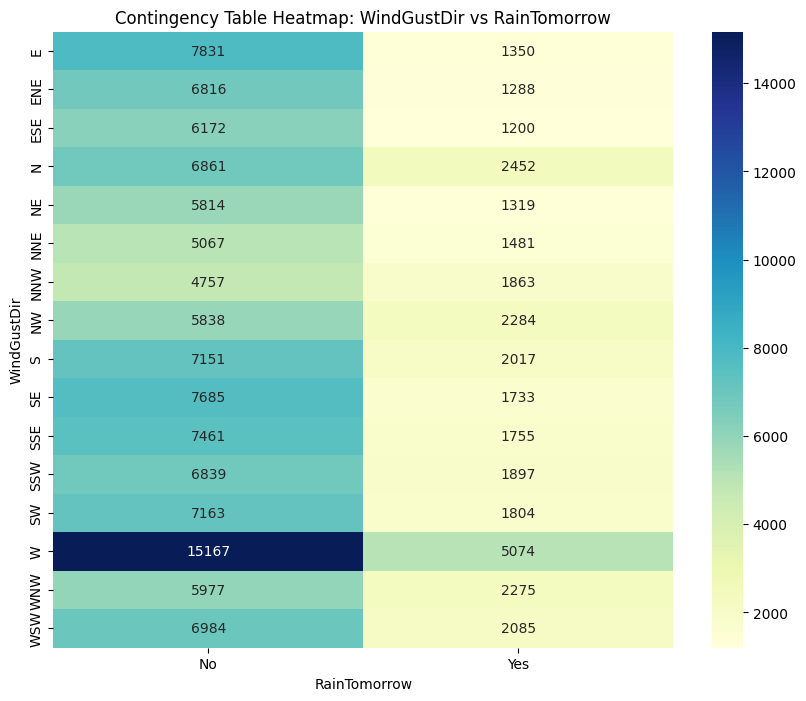

In [178]:
chi_square_test(data, "WindGustDir", "RainTomorrow")

In [179]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

<Axes: xlabel='WindGustSpeed', ylabel='Count'>

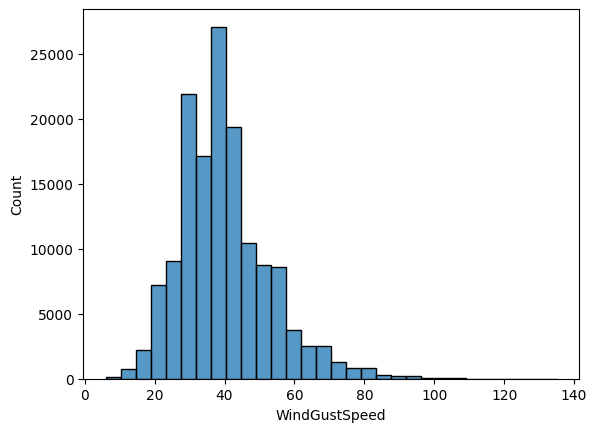

In [180]:
sns.histplot(data= data, x= 'WindGustSpeed', bins=30)

T-test results between 'No' and 'Yes':
T-statistic: -75.778
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


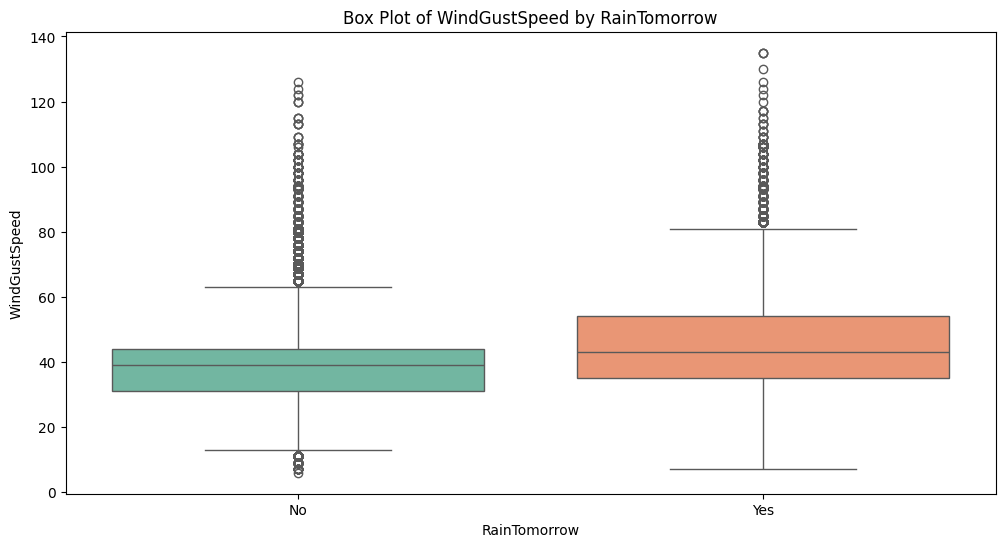

In [181]:
# testing it with ttest ind

ttest_two_categories(data, 'WindGustSpeed', 'RainTomorrow')

<Axes: xlabel='Humidity9am', ylabel='Count'>

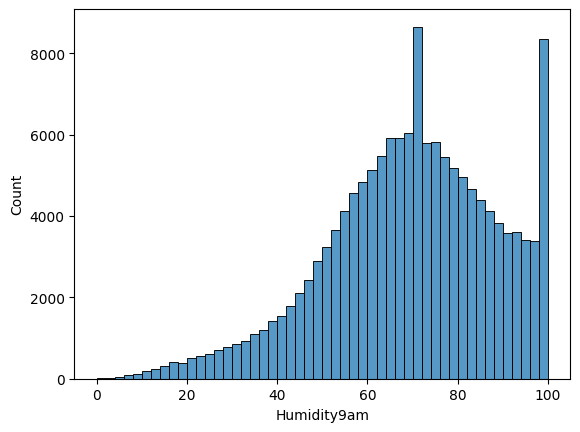

In [182]:
sns.histplot(data=data, x='Humidity9am', bins=50)

T-test results between 'No' and 'Yes':
T-statistic: -108.483
P-value: 0.000
The result is statistically significant (p < 0.05).


/tmp/ipykernel_4231/3073317488.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y=numerical_col, data=data, palette='Set2')


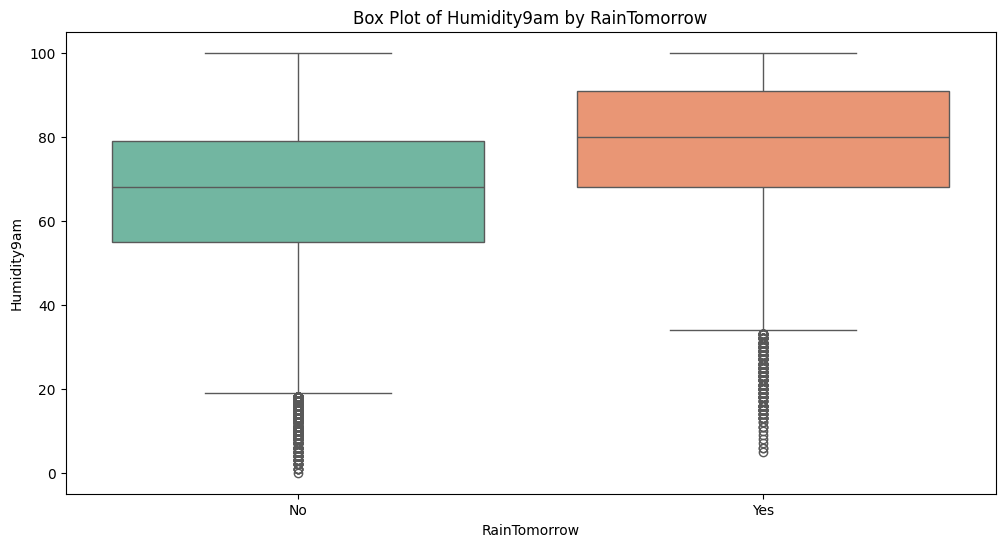

In [183]:
ttest_two_categories(data, 'Humidity9am', 'RainTomorrow')

In [184]:
# Checking the relation between raining today and raining tomorow
data.RainToday.value_counts()

RainToday
No     113580
Yes     31880
Name: count, dtype: int64

Chi-Square test between 'RainToday' and 'RainTomorrow':
Chi-Square Statistic: 13595.740
P-value: 0.000
Degrees of Freedom: 1
The result is statistically significant (p < 0.05).


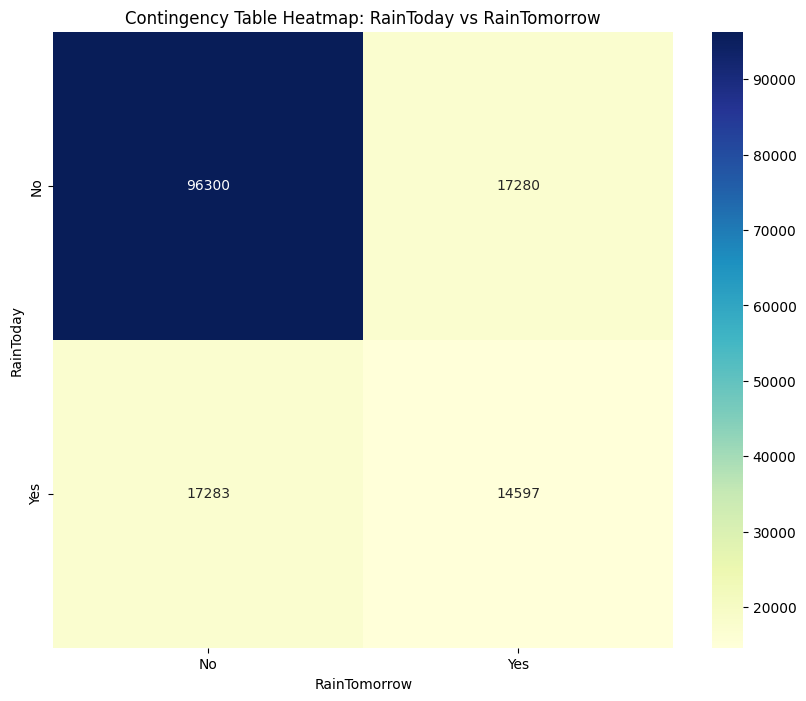

In [185]:
chi_square_test(data, "RainToday", "RainTomorrow")

In [186]:
data['year'] = pd.to_datetime(data.Date).dt.year


* Thats enough for EDA

##### Handing outliers 

In [187]:
from scipy import stats
import numpy as np

def handle_outliers(df, impute_strategy='median'):
    """
    Handle outliers in the numerical columns of the DataFrame using the specified imputation strategy.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the data.
    - impute_strategy: str, optional
        The strategy for imputing outliers. Options are 'median' or 'mean'. Default is 'median'.

    Returns:
    - df: pd.DataFrame
        The DataFrame with outliers handled.
    """
    # Select only numerical columns
    num_col = df.select_dtypes(include=[np.number]).columns
    
    for col in num_col:
        # Skip columns that are not numerical
        if pd.api.types.is_numeric_dtype(df[col]):
            # Calculate Z-scores
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            
            # Identify outliers
            outliers = np.where(z_scores > 2)[0]
            
            # Check if there are outliers to handle
            if len(outliers) == 0:
                continue
            
            # Impute outliers with specified strategy
            if impute_strategy == 'median':
                imputed_value = df[col].median()
            elif impute_strategy == 'mean':
                imputed_value = df[col].mean()
            else:
                raise ValueError("Impute strategy must be either 'median' or 'mean'.")
            
            # Replace outliers with the imputed value
            df.loc[df.index[outliers], col] = imputed_value

    return df


In [188]:
import pandas as pd

def handle_outliers_IQR(df):
    num_col = df.select_dtypes(exclude='object').columns
    for col in num_col:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        TQR = 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[col] < (Q1 - TQR)) | (df[col] > (Q3 + TQR))][col]
        
        # Impute outliers with median
        med_value = df[col].median()
        df.loc[outliers.index, col] = med_value
    
    return df

In [189]:
data = handle_outliers(data)
data = handle_outliers_IQR(data)
num_col = data.select_dtypes(exclude='object').columns


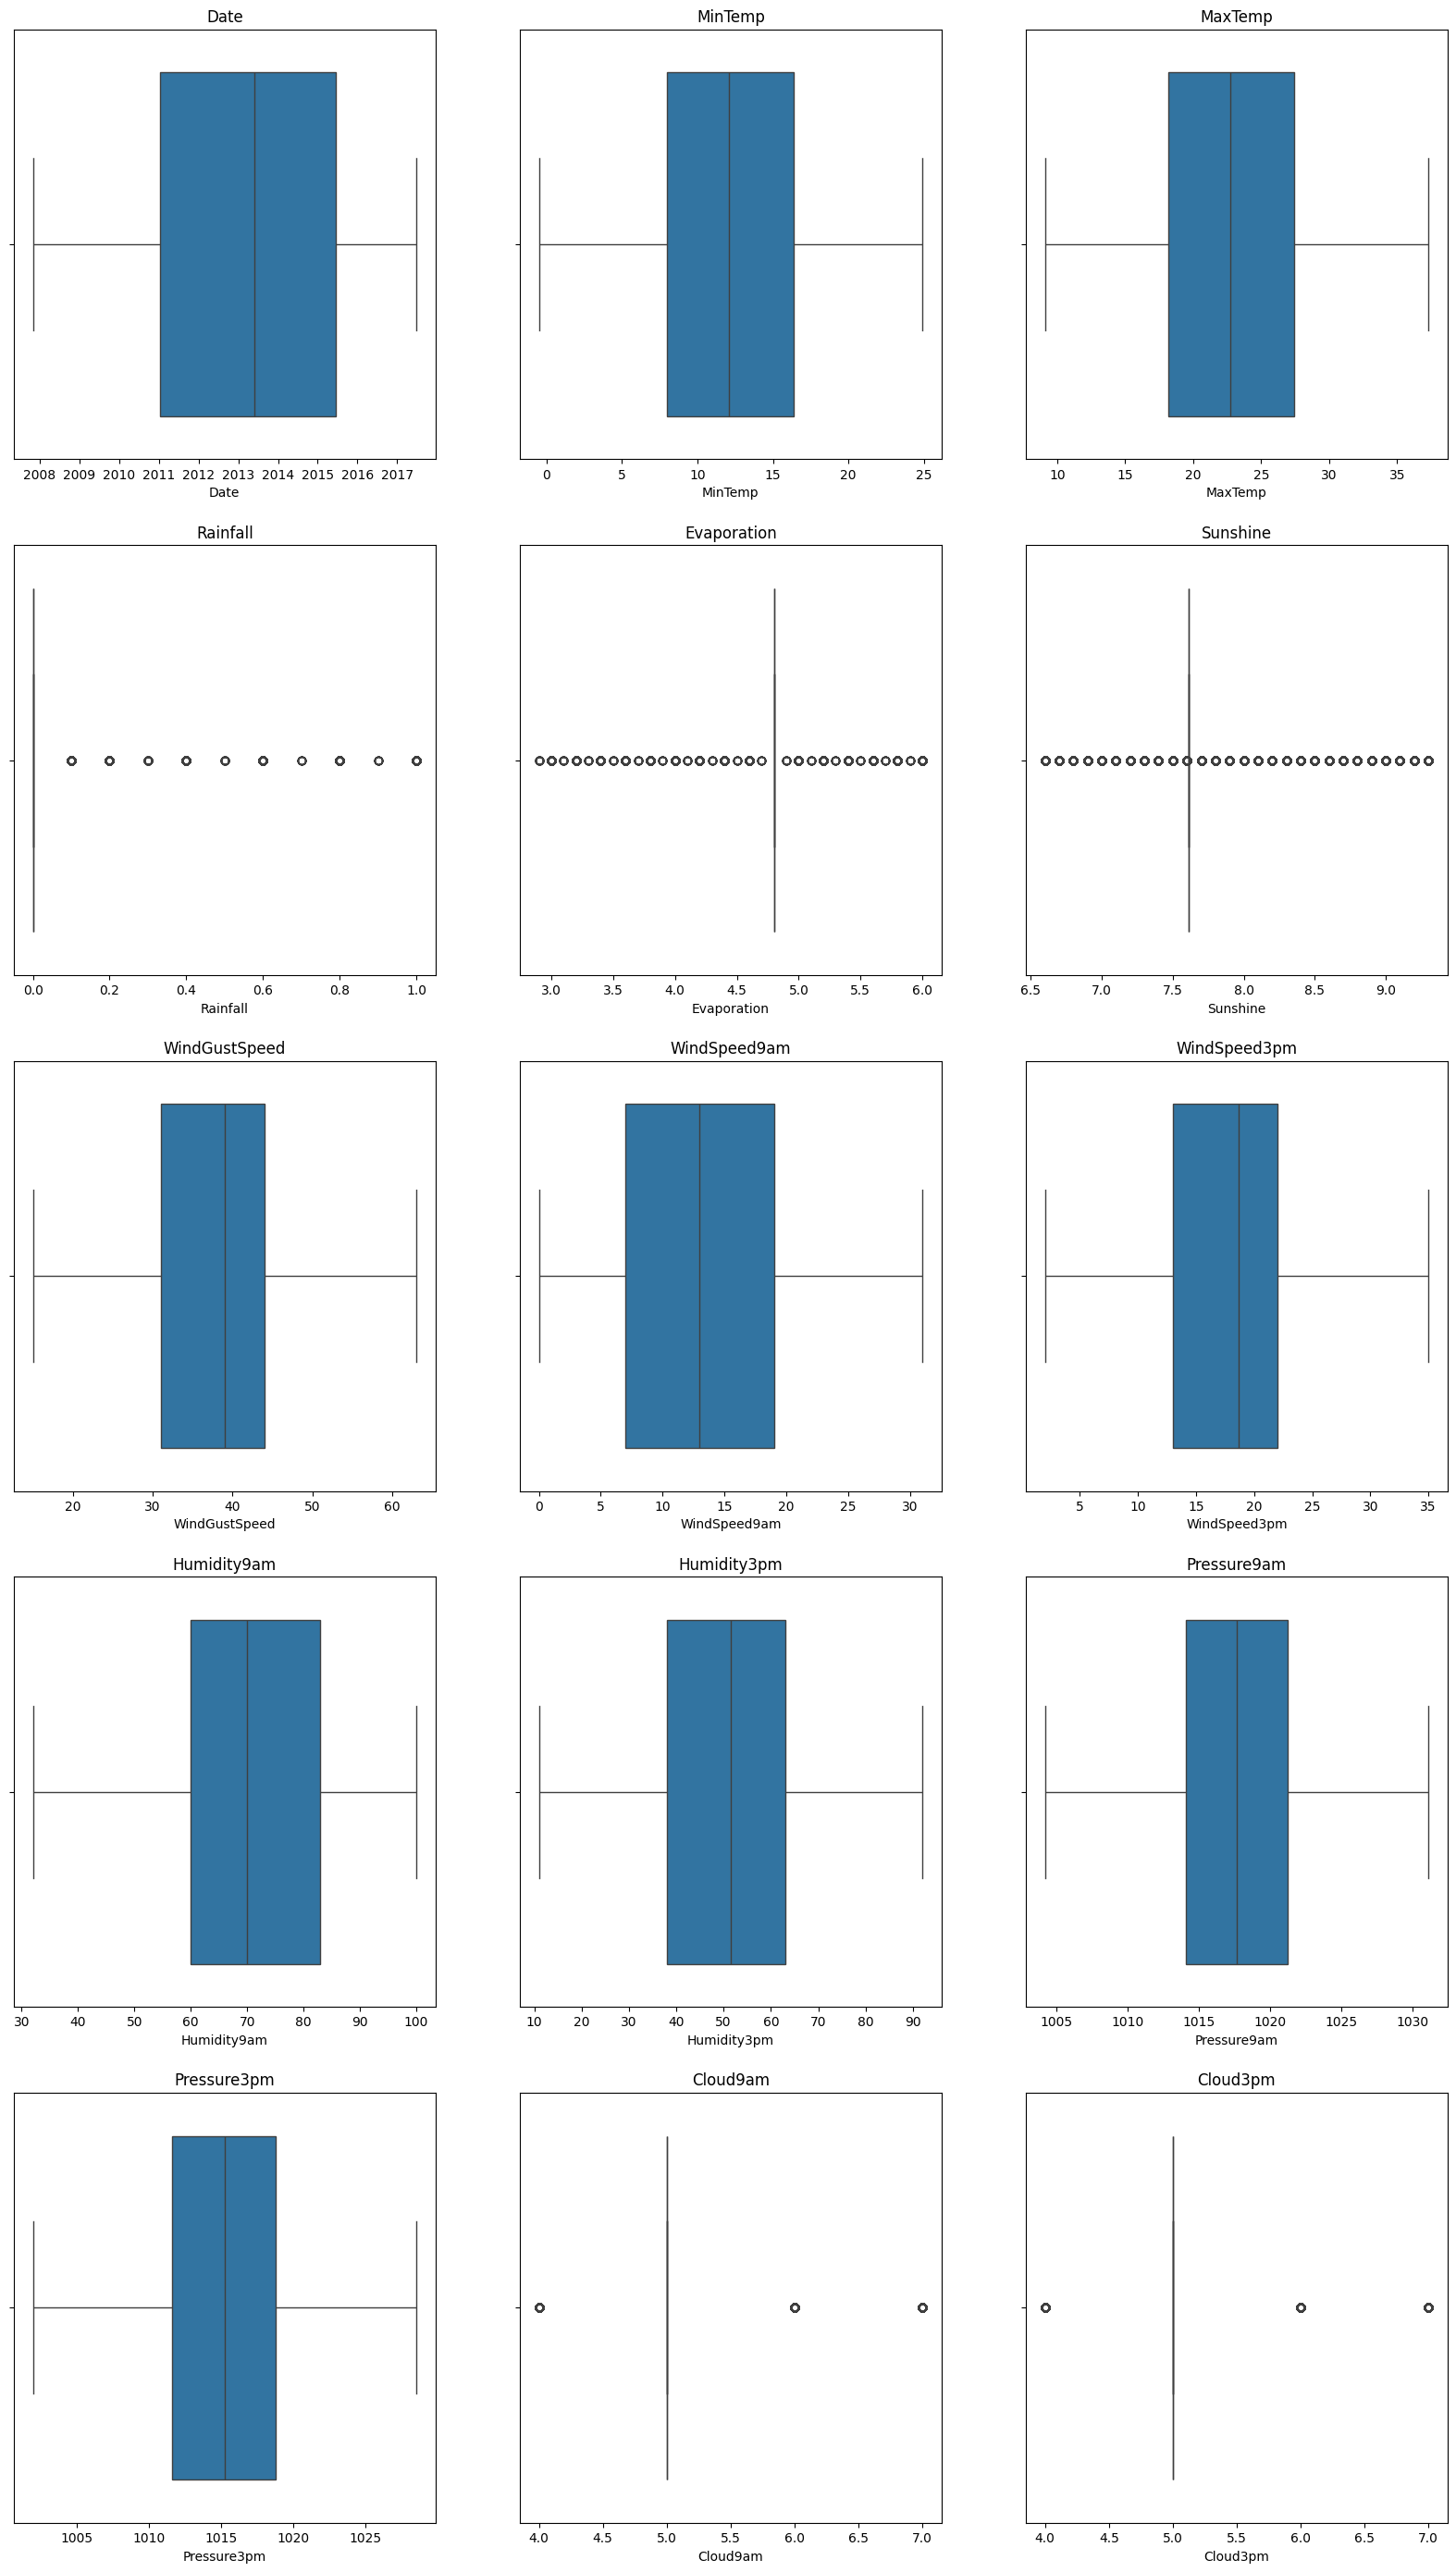

In [190]:
fig,ax=plt.subplots(5,3,figsize=(20,35))
idx=0

for i in range(5):
    for j in range(3):
        sns.boxplot(ax=ax[i, j], x=data[num_col[idx]])
        ax[i, j].set_title(num_col[idx])
        idx=idx+1

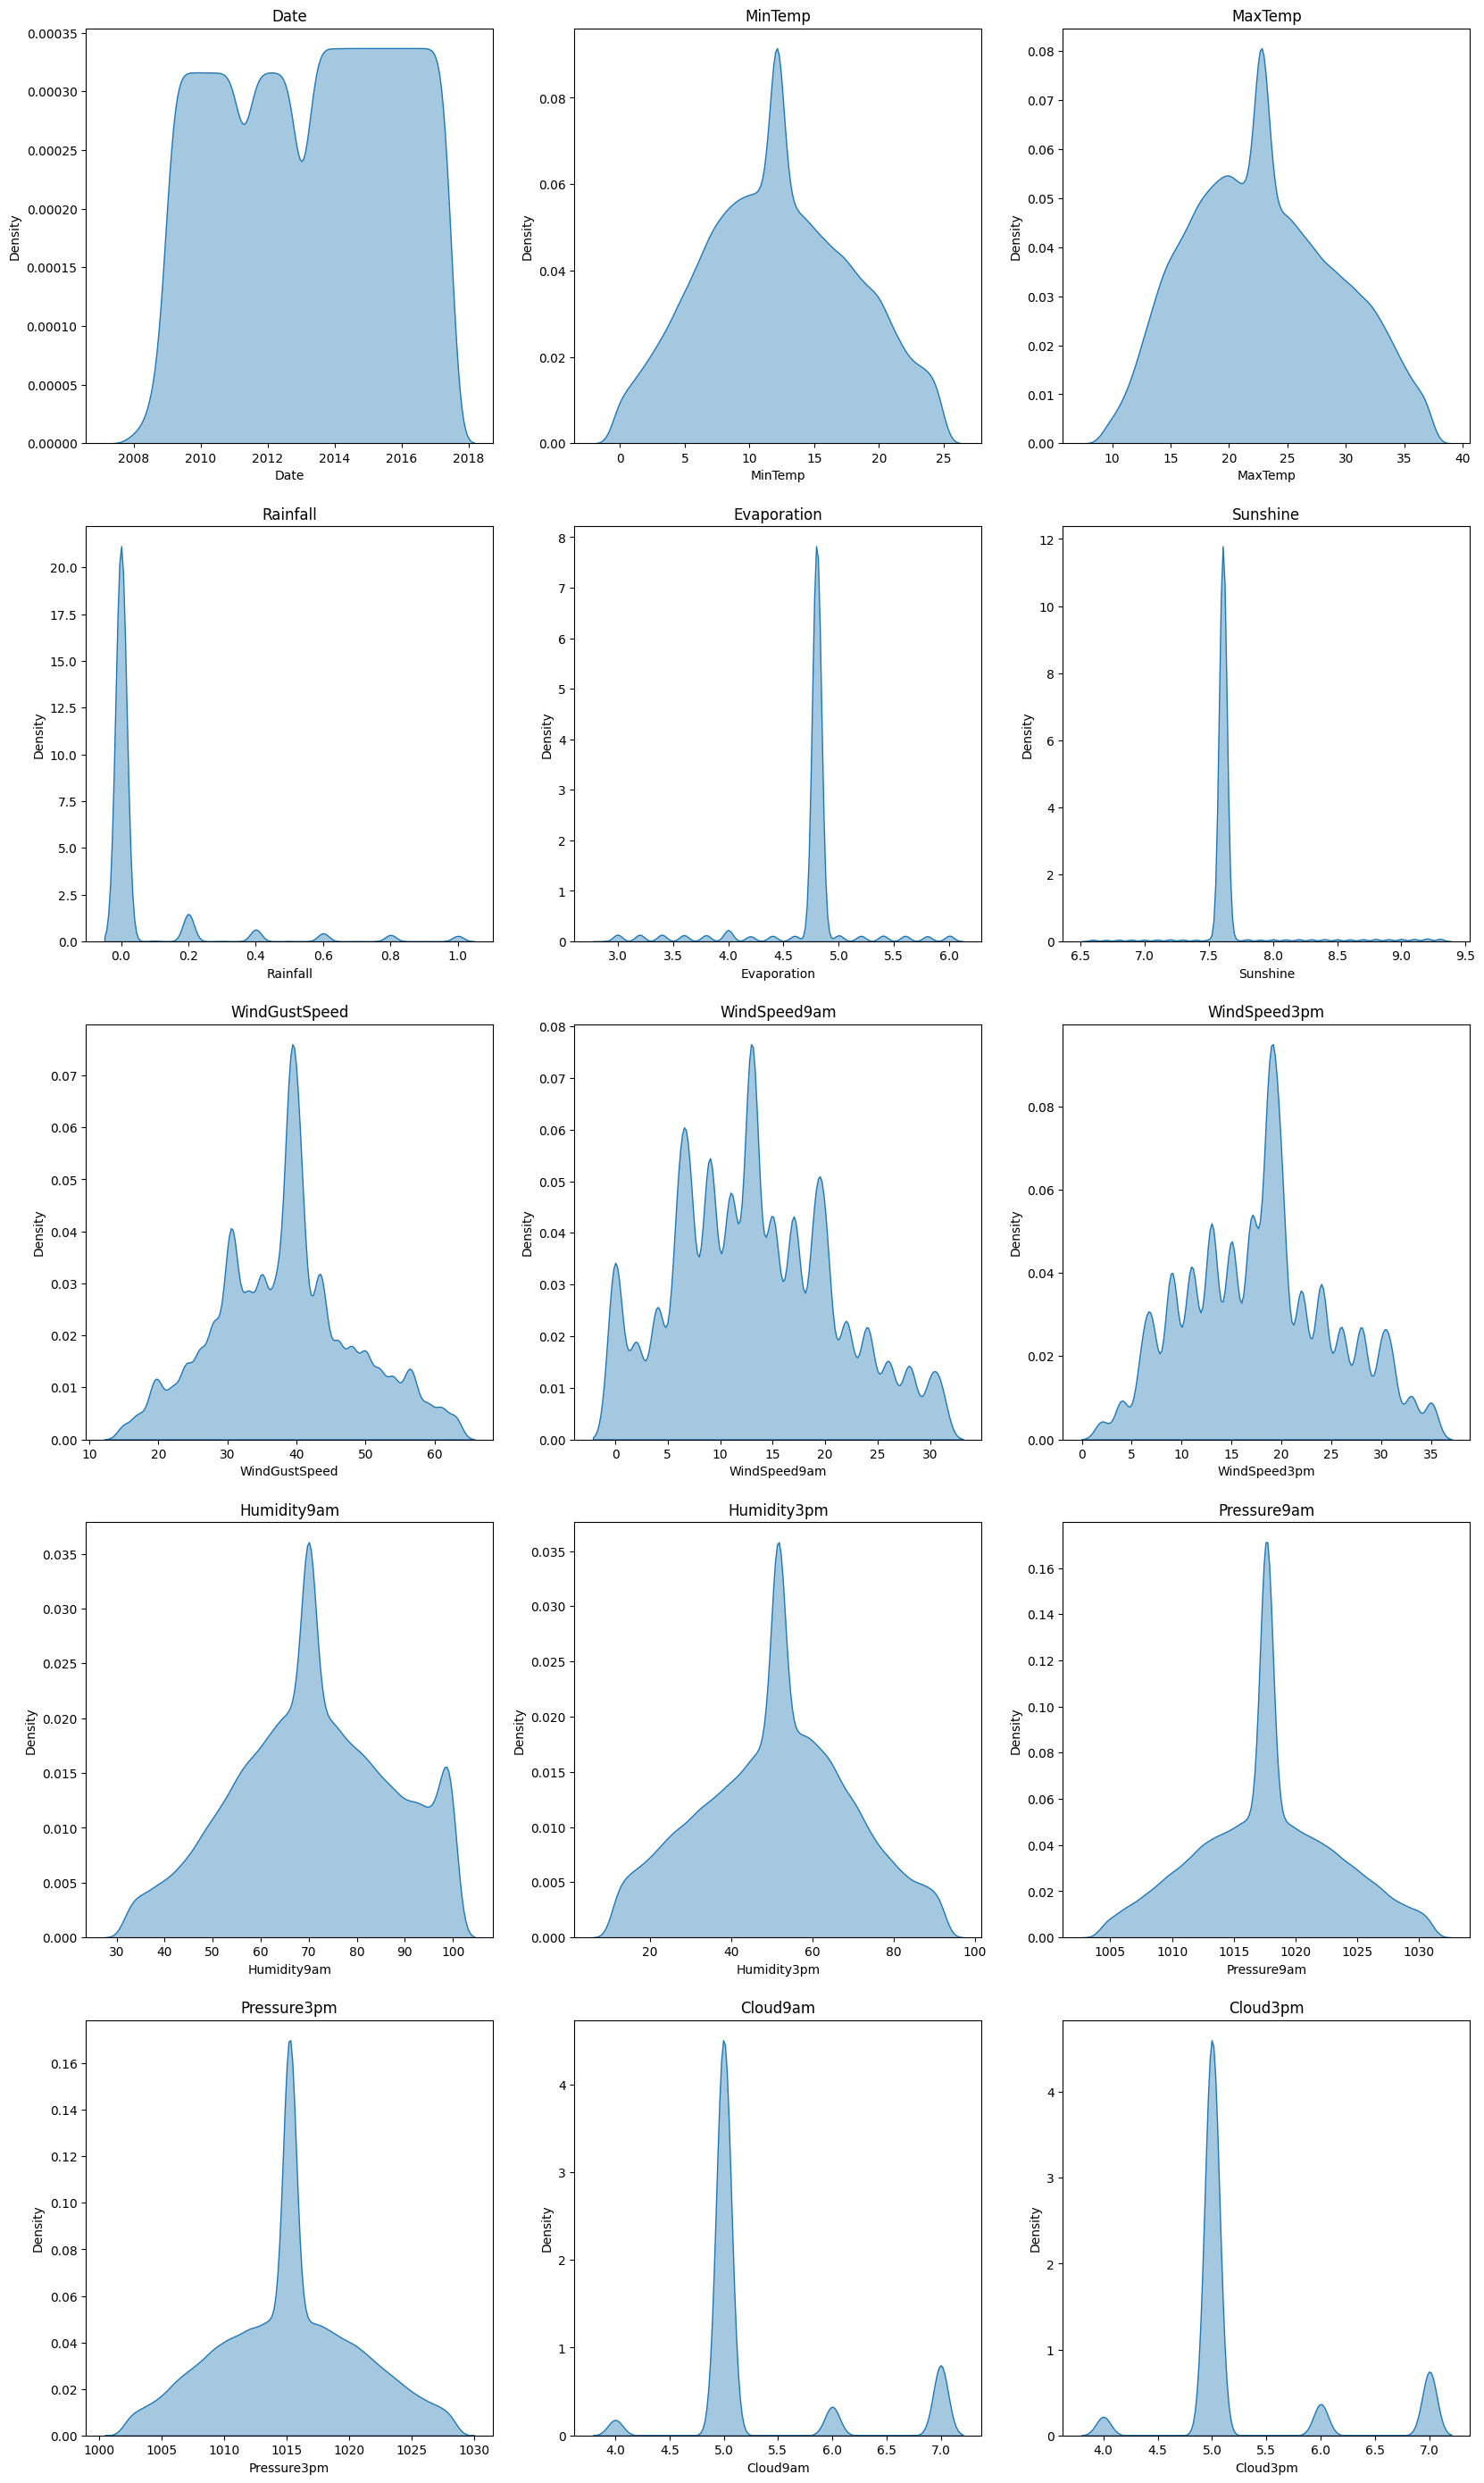

In [191]:
fig,ax=plt.subplots(5,3,figsize=(20,35))
idx=0
for i in range(5):
    for j in range(3):
        sns.kdeplot(ax=ax[i, j], x=data[num_col[idx]],alpha=0.4,fill=True)
        ax[i, j].set_title(num_col[idx])
        idx=idx+1

## Machine learing part

In [192]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'year'],
      dtype='object')

In [193]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5)

In [194]:
data2 = data.copy()

In [195]:
# Set the data frame index to be time 
data2.set_index('year', inplace=True)
data2.sort_index(inplace=True)
X = data2.drop(labels=['RainTomorrow'], axis=1)
y = data2['RainTomorrow']

In [196]:
# Splitting the dataset into training and test set
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [197]:
# Splitting the dataset into training and val set

for train_index, val_index in tss.split(X_train):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index,:]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [198]:
# Extracting the numirecal columns and object columns 
numerical_columns = X_train.select_dtypes(include='number').columns
categorical_columns = X_train.select_dtypes(include='object').columns

In [199]:
# Define preprocessing for numerical data
numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("normalization", StandardScaler())
])

# Define Preprocessing for categorical data
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [200]:
# combine steps together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [201]:
# Fitting training set on the preprocessor
 
X_train_trans = preprocessor.fit_transform(X_train)
X_val_trans =  preprocessor.fit_transform(X_val)
X_test_trans = preprocessor.fit_transform(X_test)

In [202]:
# # trianing the model on RFclassifier 
# RFclass = RandomForestClassifier()
# RFclass.fit(X_train_trans, y_train)


In [203]:
# Importing trianed model

RFclass = joblib.load('model.pkl') 


In [204]:
y_pred = RFclass.predict(X_train_trans)
y_val_pred = RFclass.predict(X_val_trans)


In [205]:
trained_accuracy = accuracy_score(y_train, y_pred); val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {trained_accuracy}, val_accuracy: {val_accuracy}')

Accuracy: 0.8417066772261546, val_accuracy: 0.8325413325413326


In [206]:
# Getting precision and recall for the model 
train_precision = precision_score(y_train, y_pred, pos_label='Yes');train_recall = recall_score(y_train, y_pred, pos_label='Yes')
val_precision = precision_score(y_val, y_val_pred, pos_label='Yes');val_recall = recall_score(y_val, y_val_pred, pos_label='Yes')

In [207]:
# Precision and recall for the trained data
print(f"Precision on train data: {train_precision}, Recall on train data: {train_recall}")
print(f"Precision on val data: {val_precision}, Recall on val data: {val_recall}")


Precision on train data: 0.7842110017161955, Recall on train data: 0.3896243773280079
Precision on val data: 0.706923477355544, Recall on val data: 0.3250359023456199


In [208]:
# Trying set of algorithms 

models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(random_state=42)
}

In [209]:
# Train, predict, and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_trans, y_train)
    y_pred = RFclass.predict(X_train_trans)
    y_val_pred = RFclass.predict(X_val_trans)
    trained_accuracy = accuracy_score(y_train, y_pred); val_accuracy = accuracy_score(y_val, y_val_pred)
    train_precision = precision_score(y_train, y_pred, pos_label='Yes');train_recall = recall_score(y_train, y_pred, pos_label='Yes')
    val_precision = precision_score(y_val, y_val_pred, pos_label='Yes');val_recall = recall_score(y_val, y_val_pred, pos_label='Yes')
    results[name] = {
        'trained_accuracy': trained_accuracy,
        'val_accuracy': val_accuracy,
        'train_precision': train_precision,
        "train_recall":train_recall,
        'val_precision':val_precision,
        "val_recall":val_recall
        }

        

In [210]:
for model, metrics in results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

Model: GradientBoostingClassifier
  trained_accuracy: 0.8417066772261546
  val_accuracy: 0.8325413325413326
  train_precision: 0.7842110017161955
  train_recall: 0.3896243773280079
  val_precision: 0.706923477355544
  val_recall: 0.3250359023456199
Model: LogisticRegression
  trained_accuracy: 0.8417066772261546
  val_accuracy: 0.8325413325413326
  train_precision: 0.7842110017161955
  train_recall: 0.3896243773280079
  val_precision: 0.706923477355544
  val_recall: 0.3250359023456199
Model: KNeighbors
  trained_accuracy: 0.8417066772261546
  val_accuracy: 0.8325413325413326
  train_precision: 0.7842110017161955
  train_recall: 0.3896243773280079
  val_precision: 0.706923477355544
  val_recall: 0.3250359023456199
Model: SVC
  trained_accuracy: 0.8417066772261546
  val_accuracy: 0.8325413325413326
  train_precision: 0.7842110017161955
  train_recall: 0.3896243773280079
  val_precision: 0.706923477355544
  val_recall: 0.3250359023456199


* Now the all models are overfitted so we will do some tuning for hyperprams

 By using these ensemble methods, you can often achieve better performance than any single model alone.
*  Bagging with RandomForestClassifier uses multiple decision trees and averages their predictions.
*  Boosting with GradientBoostingClassifier sequentially improves the model by focusing on misclassified samples.
*  Stacking combines different models and uses another model to synthesize their outputs.
*  Voting combines predictions from different models either by majority rule or by averaging probabilities.*

In [211]:
# First we would know feature importance to reduce useless features
rf_feature_importances = RFclass.feature_importances_
rf_feature_importances


array([0.04236509, 0.04331548, 0.04352115, 0.02503045, 0.05495322,
       0.04851019, 0.0287128 , 0.03145108, 0.05078415, 0.13303275,
       0.049638  , 0.05378102, 0.02463551, 0.033878  , 0.04024834,
       0.0473616 , 0.00166528, 0.00190851, 0.00137147, 0.00063089,
       0.00136111, 0.00135978, 0.00125516, 0.00145382, 0.00116075,
       0.00166064, 0.00099051, 0.00188199, 0.00153763, 0.00071482,
       0.00131776, 0.00154901, 0.00031456, 0.00137228, 0.00168782,
       0.0013071 , 0.00089462, 0.00104237, 0.00168439, 0.00134805,
       0.00084558, 0.00051027, 0.00149726, 0.00167948, 0.00135834,
       0.00155446, 0.0009697 , 0.00162018, 0.00135699, 0.00199357,
       0.00129526, 0.00157   , 0.00116073, 0.00186211, 0.00154749,
       0.00072606, 0.0014986 , 0.00027529, 0.00128461, 0.00176408,
       0.00140369, 0.00188154, 0.00260133, 0.00158735, 0.00081742,
       0.00225302, 0.00218386, 0.00214414, 0.0034656 , 0.00268241,
       0.00274394, 0.00317513, 0.00342388, 0.00327736, 0.00270

In [212]:
# Select features with importance greater than a threshold
from sklearn.feature_selection import SelectFromModel

threshold = 0.01  # Adjust threshold based on your requirements
sfm = SelectFromModel(RFclass, threshold=threshold)
sfm.fit(X_train_trans, y_train)
X_train_reduced = sfm.transform(X_train_trans)
X_val_reduced = sfm.transform(X_val_trans)
X_test_reduced = sfm.transform(X_test_trans)

In [213]:
X_train_reduced

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1717255 stored elements and shape (101015, 18)>

In [214]:
rf_reduced = RandomForestClassifier(random_state=42)
rf_reduced.fit(X_train_reduced, y_train)



RandomForestClassifier(random_state=42)

In [215]:
rf_reduced.feature_importances_

array([0.07189731, 0.06873859, 0.01238107, 0.01974342, 0.01912277,
       0.06251136, 0.04657703, 0.04986445, 0.0824858 , 0.17221106,
       0.07313831, 0.07858025, 0.01525063, 0.01922861, 0.0674426 ,
       0.07416808, 0.02611353, 0.04054513])

In [216]:
X_train_reduced.shape, X_val_reduced.shape, X_test_reduced.shape

((101015, 18), (20202, 18), (24243, 18))

In [217]:
y_pred_2 = rf_reduced.predict(X_train_reduced)
y_val_pred_2 = rf_reduced.predict(X_val_reduced)

In [218]:
trained_accuracy = accuracy_score(y_train, y_pred_2); val_accuracy = accuracy_score(y_val, y_val_pred_2)
print(f'Accuracy: {trained_accuracy}, val_accuracy: {val_accuracy}')

Accuracy: 0.9998317081621542, val_accuracy: 0.8398178398178399


* Feature extraction doesnt effect the overfitting 

In [227]:
trained_accuracy = accuracy_score(y_train, y_pred_3); val_accuracy = accuracy_score(y_val, y_val_pred_3)
print(f'Accuracy: {trained_accuracy}, val_accuracy: {val_accuracy}')

Accuracy: 0.8149878730881552, val_accuracy: 0.8246708246708246


* Now we adjusted the overfitting 

In [228]:
# Create a voting classifier 
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svc_clf = SVC(probability=True)
gra_clf = GradientBoostingClassifier()
RF_clf = RandomForestClassifier()  
voting_clf = VotingClassifier(
    estimators=[
        ('log', log_clf),
        ('knn', knn_clf),
        ('svc', svc_clf),
        ('gra', gra_clf),
        ('rf_clf', RF_clf)
    ],
    voting='soft'  # Use 'soft' voting for probability-based predictions
)

In [229]:
vot_clf = voting_clf.fit(X_train_reduced, y_train)

In [230]:
y_pred_3 = vot_clf.predict(X_train_reduced)
y_val_pred_3 = vot_clf.predict(X_val_reduced)

In [231]:
trained_accuracy = accuracy_score(y_train, y_pred_3); val_accuracy = accuracy_score(y_val, y_val_pred_3)
print(f'Accuracy: {trained_accuracy}, val_accuracy: {val_accuracy}')

Accuracy: 0.8774736425283374, val_accuracy: 0.8407583407583408


In [233]:
# Getting precision and recall for the model 
train_precision = precision_score(y_train, y_pred_3, pos_label='Yes');train_recall = recall_score(y_train, y_pred_3, pos_label='Yes')
val_precision = precision_score(y_val, y_val_pred_3, pos_label='Yes');val_recall = recall_score(y_val, y_val_pred_3, pos_label='Yes')

In [234]:
# Precision and recall for the trained data
print(f"Precision on train data: {train_precision}, Recall on train data: {train_recall}")
print(f"Precision on val data: {val_precision}, Recall on val data: {val_recall}")


Precision on train data: 0.8683075550267698, Recall on train data: 0.5240317731005699
Precision on val data: 0.7119541243934715, Recall on val data: 0.38630923887027285


In [232]:
import joblib

# Save the model to a file
filename = 'voting_ensemble_model.pkl'
joblib.dump(voting_clf, filename)

['voting_ensemble_model.pkl']